In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun May 27 15:21:41 2018

@author: james.macdonald
"""

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import datetime as dt
import random, subprocess, os
from scipy.io import loadmat

tf.__version__

/home/james/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


'1.8.0'

In [2]:
def download_dataset(url):
    fname = url.split("/")[-1]
    if fname not in os.listdir('./'):
        cmd = 'wget '+url
        subprocess.call(cmd, shell=True)
    return fname
    
train = download_dataset('http://ufldl.stanford.edu/housenumbers/train_32x32.mat')
test = download_dataset('http://ufldl.stanford.edu/housenumbers/test_32x32.mat')
extra = download_dataset('http://ufldl.stanford.edu/housenumbers/extra_32x32.mat')

train = 'train_32x32.mat'
test = 'test_32x32.mat'
extra = 'extra_32x32.mat'

#data_dic = {i:loadmat(i) for i in [train,test]} # include extra in list for extra

#X = np.array([data_dic['train_32x32.mat']['X'][:,:,:,i] for i in range(data_dic['train_32x32.mat']['X'].shape[3])])
#y = np.array(data_dic['train_32x32.mat']['y'])
#y[y==10] = 0

def to_greyscale(data):
    return np.dot(data, np.array([0.299, 0.587, 0.114]))

In [3]:
def get_shuffled_index(count_obs, mbatch_size = 250):
    ix = np.array(range(count_obs))
    np.random.shuffle(ix)
    return ix

class Dataset(object):
    
    def __init__(self, location):
        data_dic = loadmat(location)
        self._images = to_greyscale(np.array([data_dic['X'][:,:,:,i] for i in range(data_dic['X'].shape[3])]))
        self._num_examples = len(self._images)
        self._cls = np.array(data_dic['y'][:,0])
        self._cls[self._cls==10] = 0
        labels = np.zeros([len(self._cls),10])
        labels[range(len(labels)),self._cls] = 1
        self._labels = labels
        self._index_in_epoch = 0
        self._img_names = self._labels
        self._epochs_done = 0
        
    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._labels

    @property
    def img_names(self):
        return self._img_names

    @property
    def cls(self):
        return self._cls

    @property
    def num_examples(self):
        return self._num_examples
    

    def next_batch(self, batch_size):
        """Return the next `batch_size` examples from this data set."""
        start = self._index_in_epoch
        self._index_in_epoch += batch_size

        if self._index_in_epoch > self._num_examples:
            # After each epoch we update this
            self._epochs_done += 1
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch

        return self._images[start:end], self._labels[start:end], self._img_names[start:end], self._cls[start:end]
    
def read_train_sets():
    class DataSets(object):
        pass
    data_sets = DataSets()
    
    data_sets.train = Dataset(train)
    data_sets.validation = Dataset(test)
    
    return data_sets

data = read_train_sets()

In [4]:
def plot_images(images, cls_true, img_shape=None, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape((img_size,img_size)), cmap='binary')

        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

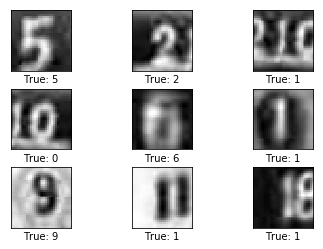

In [5]:
validation_size = 0.2
img_size = 32
num_channels = 1
num_classes = 10
batch_size = 132
train_batch_size = batch_size

img_size_flat = img_size * img_size * num_channels
img_shape = (img_size, img_size, num_channels)

images = data.validation.images[0:9]
cls_true = data.validation.cls[0:9]

plot_images(images=images, cls_true=cls_true)

In [6]:

# ### *Step 2:* Configuration of CNNs
# 
# The configuration of the Convolutional Neural Network is defined here for convenience, so you can easily find and change these numbers and re-run the Notebook.

# In[7]:

# Exp 3 : 10000 iterations val accuracy:22.5
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.
stride_size1 = 1

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 32         # There are 36 of these filters.
stride_size2 = 1

# Convolutional Layer 3.
filter_size3 = 5          # Convolution filters are 5 x 5 pixels.
num_filters3 = 64         # There are 36 of these filters.
stride_size3 = 1

# Convolutional Layer 2.
filter_size4 = 5          # Convolution filters are 5 x 5 pixels.
num_filters4 = 128         # There are 36 of these filters.
stride_size4 = 1


# Fully-connected layer.
fc_size = 500             # Number of neurons in fully-connected layer.
dropout = 0.1

regularization_coefficient = 0.01


In [7]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))


def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   stride_size,        # Stride over x- and y- channel
                   use_pooling=True):  # Use 2x2 max-pooling.

    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = new_weights(shape=shape)
    biases = new_biases(length=num_filters)
    strides =[1, stride_size, stride_size, 1]
    
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=strides,
                         padding='SAME')

    layer += biases
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    layer = tf.nn.relu(layer)
    return layer, weights

def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features


def new_fc_layer(input, num_inputs, num_outputs, use_relu=True, dropout=0.05): 
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    layer = tf.matmul(input, weights) + biases
    if use_relu:
        layer = tf.nn.relu(layer)
    layer = tf.nn.dropout(layer, 1-dropout)
    return layer, weights


In [9]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)


layer_conv1, weights_conv1 =     new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   stride_size=stride_size1,
                   use_pooling=False)

layer_conv2, weights_conv2 =     new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   stride_size=stride_size2,
                   use_pooling=True)

layer_conv3, weights_conv3 =     new_conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   stride_size=stride_size3,
                   use_pooling=False)

layer_conv4, weights_conv4 =     new_conv_layer(input=layer_conv3,
                   num_input_channels=num_filters3,
                   filter_size=filter_size4,
                   num_filters=num_filters4,
                   stride_size=stride_size4,
                   use_pooling=True)

layer_flat, num_features = flatten_layer(layer_conv4)


layer_fc1, fc1_weights = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

layer_fc2, fc2_weights = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, axis=1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2, labels=y_true)

cost = tf.reduce_mean(cross_entropy)
regularizers = tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc2_weights)
cost = tf.reduce_mean(cost + regularization_coefficient * regularizers)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [12]:


def optimize(num_iterations):
    global total_iterations
    global train_scores

    for i in range(total_iterations,
                   total_iterations + num_iterations):
        
        x_batch, y_true_batch, _, _ = data.train.next_batch(train_batch_size)
        feed_dict_train = {x: x_batch,y_true: y_true_batch}

        session.run(optimizer, feed_dict=feed_dict_train)

        if i % 10 == 0:
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            train_scores.append(acc)
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            print(msg.format(i + 1, acc))
    total_iterations += num_iterations



In [13]:
# Split the validation-set into smaller batches of this size.
validation_batch_size = 256

def print_validation_accuracy():
    num_validation = len(data.validation.images)
    cls_pred = np.zeros(shape=num_validation, dtype=np.int)
    i = 0
    while i < num_validation:
        j = min(i + validation_batch_size, num_validation)
        images = data.validation.images[i:j, :]
        labels = data.validation.labels[i:j, :]
        feed_dict = {x: images,y_true: labels}
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        i = j
    cls_true = data.validation.cls
    correct = (cls_true == cls_pred)
    acc = float(correct.sum()) / num_validation
    msg = "Accuracy on validation-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_validation))



In [15]:
np.random.seed(1)
session = tf.Session()
session.run(tf.global_variables_initializer())

total_iterations = 0
train_scores = []

optimize(num_iterations=200)

Optimization Iteration:      1, Training Accuracy:  11.4%
Optimization Iteration:     11, Training Accuracy:   9.8%
Optimization Iteration:     21, Training Accuracy:  15.2%
Optimization Iteration:     31, Training Accuracy:  19.7%
Optimization Iteration:     41, Training Accuracy:  21.2%
Optimization Iteration:     51, Training Accuracy:  18.9%
Optimization Iteration:     61, Training Accuracy:  21.2%
Optimization Iteration:     71, Training Accuracy:  21.2%
Optimization Iteration:     81, Training Accuracy:  25.8%
Optimization Iteration:     91, Training Accuracy:  34.8%
Optimization Iteration:    101, Training Accuracy:  37.1%
Optimization Iteration:    111, Training Accuracy:  34.8%
Optimization Iteration:    121, Training Accuracy:  44.7%
Optimization Iteration:    131, Training Accuracy:  46.2%
Optimization Iteration:    141, Training Accuracy:  35.6%
Optimization Iteration:    151, Training Accuracy:  42.4%
Optimization Iteration:    161, Training Accuracy:  33.3%
Optimization I

In [14]:
np.random.seed(1)
session = tf.Session()
session.run(tf.global_variables_initializer())

total_iterations = 0
train_scores = []

optimize(num_iterations=200)

Optimization Iteration:      1, Training Accuracy:   9.8%
Optimization Iteration:     11, Training Accuracy:  12.9%
Optimization Iteration:     21, Training Accuracy:   9.1%
Optimization Iteration:     31, Training Accuracy:  13.6%
Optimization Iteration:     41, Training Accuracy:  15.2%
Optimization Iteration:     51, Training Accuracy:  22.7%
Optimization Iteration:     61, Training Accuracy:  23.5%
Optimization Iteration:     71, Training Accuracy:  22.0%
Optimization Iteration:     81, Training Accuracy:  22.0%
Optimization Iteration:     91, Training Accuracy:  28.8%
Optimization Iteration:    101, Training Accuracy:  31.8%
Optimization Iteration:    111, Training Accuracy:  32.6%
Optimization Iteration:    121, Training Accuracy:  34.8%
Optimization Iteration:    131, Training Accuracy:  36.4%
Optimization Iteration:    141, Training Accuracy:  37.9%
Optimization Iteration:    151, Training Accuracy:  32.6%
Optimization Iteration:    161, Training Accuracy:  45.5%
Optimization I

In [86]:
optimize(num_iterations=2000)

Optimization Iteration:      1, Training Accuracy:  14.0%
Optimization Iteration:    101, Training Accuracy:  36.0%
Optimization Iteration:    201, Training Accuracy:  43.0%
Optimization Iteration:    301, Training Accuracy:  52.0%
Optimization Iteration:    401, Training Accuracy:  70.0%
Optimization Iteration:    501, Training Accuracy:  69.0%
Optimization Iteration:    601, Training Accuracy:  67.0%
Optimization Iteration:    701, Training Accuracy:  79.0%
Optimization Iteration:    801, Training Accuracy:  71.0%
Optimization Iteration:    901, Training Accuracy:  77.0%
Optimization Iteration:   1001, Training Accuracy:  81.0%
Optimization Iteration:   1101, Training Accuracy:  86.0%
Optimization Iteration:   1201, Training Accuracy:  81.0%
Optimization Iteration:   1301, Training Accuracy:  79.0%
Optimization Iteration:   1401, Training Accuracy:  83.0%
Optimization Iteration:   1501, Training Accuracy:  85.0%
Optimization Iteration:   1601, Training Accuracy:  86.0%
Optimization I